# Markov Chain Monte Carlo Example 1
Author: Audrey Olivier, Dimitris G. Giovanis, Michael D. Shields <br>
Last modified: October 2019 by Audrey Olivier

In this example, the Metropolis-Hastings is employed to generate samples from a Rosenbrock distribution. The method illustrates various aspects of the UQpy MCMC class:
- various ways of defining the target pdf to sample from,
- definition of input parameters required by the algorithm (proposal_type and proposal_scale for MH),
- running several chains in parallel,
- call diagnostics functions.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the MCMC class from UQpy.

In [1]:
from UQpy.SampleMethods import MCMC
from UQpy.Distributions import Distribution
import numpy as np
import matplotlib.pyplot as plt
import time

## Explore various ways of defining the target pdf

Define the Rosenbrock probability density function up to a scale factor. Here the pdf is defined directly in the python script <br>
- define the Rosenbrock probability density function up to a scale factor, this function only takes as input parameter the point x where to compute the pdf, <br>
- define a pdf function that also takes as argument a set of parameters params,
- define a function that computes the log pdf up to a constant.
Alternatively, the pdf can be defined in an external file that defines a distribution and its pdf or log_pdf methods (Rosenbrock.py)

In [2]:
def Rosenbrock_no_params(x):
     return np.exp(-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)
    
def Rosenbrock(x, params):
     return np.exp(-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/params[0])
    
def log_Rosenbrock(x):
     return (-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)

(500, 2)


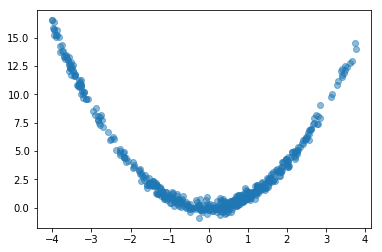

In [3]:
x = MCMC(dimension=2, pdf_target=Rosenbrock_no_params, algorithm='MH', nburn=500, jump=50, nsamples=500)
print(x.samples.shape)
plt.plot(x.samples[:,0], x.samples[:,1], 'o', alpha=0.5)
plt.show()

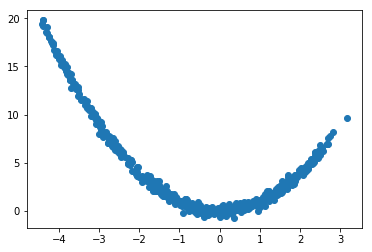

In [4]:
x = MCMC(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500,
         pdf_target=Rosenbrock, args_target = ([20], ))
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

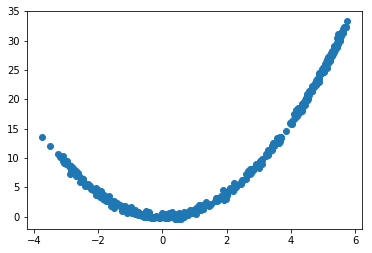

In [5]:
x = MCMC(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
         log_pdf_target=log_Rosenbrock)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

In the following, the Rosenbrock.py file is used. It must have a pdf method (if input pdf_target is used) or a log pdf method (if input log_pdf_target is used).

In [6]:
pdf_target = Distribution('Rosenbrock').pdf
x = MCMC(dimension=2, algorithm='MH', nburn=500, jump=50, nsamples=500, seed=None, 
         pdf_target=pdf_target, args_target = ([20], ))

## The algorithm-specific parameters for MH are proposal and proposal_params and proposal_is_symmetric

The default values proposal is standard normal (symmetric).

proposal should be a Distribution object


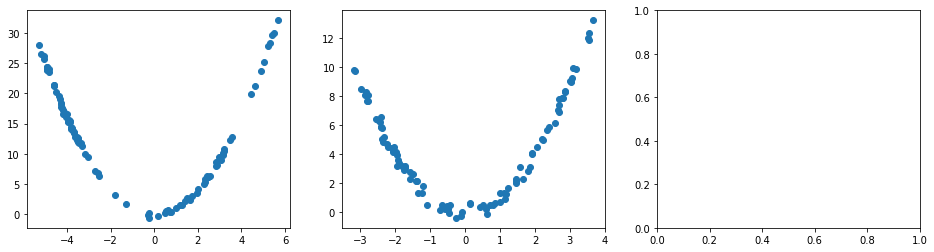

In [7]:
proposals = [Distribution(['normal', 'normal']), Distribution(['uniform', 'uniform']), 'normal']
proposals_params = [[[0., 1.], [0., 1.]], [[-0.5, 1.5], [-0.5, 1.5]], None]
proposals_is_symmetric = [True, False, False]
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
for i, (proposal, proposal_params, symm) in enumerate(zip(proposals, proposals_params, proposals_is_symmetric)):
    try:
        x = MCMC(dimension=2, algorithm='MH', nburn=100, jump=400, nsamples=100, log_pdf_target=log_Rosenbrock,
                 proposal=proposal, proposal_params=proposal_params, proposal_is_symmetric=symm)
        ax[i].plot(x.samples[:, 0], x.samples[:, 1], 'o')
    except TypeError as e:
        print(e)
plt.show()

Not providing the input proposal_type works - the default value 'normal' is used

## Run several chains in parallel

The user can provide the total number of samples nsamples, or the number of samples per chain nsamples_per_chain.

(50, 2, 2)


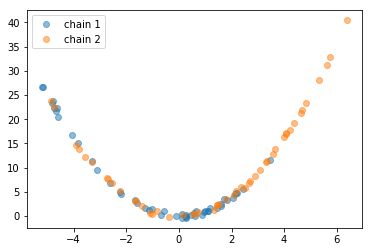

In [8]:
x = MCMC(dimension=2, log_pdf_target=log_Rosenbrock, algorithm='MH', jump=1000, 
         nsamples=100, nburn=500, seed=np.array([[0., 0.], [1., 1.]]), concat_chains_=False)
plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', label='chain 1', alpha=0.5)
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', label='chain 2', alpha=0.5)
print(x.samples.shape)
plt.legend()
plt.show()

(100, 2, 2)


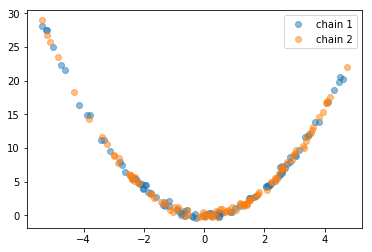

In [9]:
x = MCMC(dimension=2, log_pdf_target=log_Rosenbrock, algorithm='MH', jump=1000, 
         nsamples_per_chain=100, nburn=500, seed=np.array([[0., 0.], [1., 1.]]), concat_chains_=False)
plt.plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o', label='chain 1', alpha=0.5)
plt.plot(x.samples[:, 1, 0], x.samples[:, 1, 1], 'o', label='chain 2', alpha=0.5)
print(x.samples.shape)
plt.legend()
plt.show()

## Initialize without nsamples... then call run

In [10]:
t = time.time()
x = MCMC(dimension=2, log_pdf_target=log_Rosenbrock, algorithm='MH', jump=1000, 
            nburn=500, seed=np.array([[0., 0.], [1., 1.]]), verbose=True, concat_chains_=False)
print('Elapsed time for initialization: {} s'.format(time.time()-t))

Initialization of mcmc algorithm MH completed.
Elapsed time for initialization: 0.00038623809814453125 s


Running MCMC...
MCMC run successfully !
Elapsed time for running MCMC: 5.461410045623779 s
nburn, jump at first run: 500, 1000
total nb of samples: 50


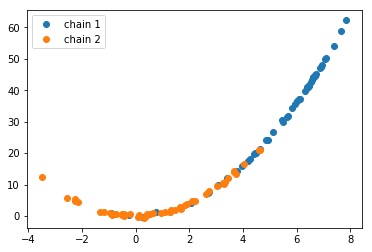

In [11]:
t = time.time()
x.run(nsamples=100)
print('Elapsed time for running MCMC: {} s'.format(time.time()-t))
print('nburn, jump at first run: {}, {}'.format(x.nburn, x.jump))
print('total nb of samples: {}'.format(x.samples.shape[0]))

plt.plot(x.samples[:, 0, 0],x.samples[:, 0, 1],'o', label='chain 1')
plt.plot(x.samples[:, 1, 0],x.samples[:, 1, 1],'o', label='chain 2')
plt.legend()
plt.show()